In [56]:
modelName = "convnext-unetplusplus-espcn-modified"
espcn = True

In [57]:
import os
import torch
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
from torchvision import transforms
from collections import OrderedDict
from Models.EncoderModel import EncoderModelResNet, EncoderModelConvNeXt
from Models.DecoderModel import DepthDecoderModelUNET, DepthDecoderModelUNETPlusPlus
from Models.CameraNet import CameraNet, CameraIntrinsics
from utils import dispToDepth

In [58]:
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
path = os.path.join("models/{}".format(modelName), "weights_19")

In [60]:
if "resnet" in modelName:
    enc = EncoderModelResNet(50)
elif "convnext" in modelName:
    enc = EncoderModelConvNeXt()
else:
    raise Exception("Encoder not found.")
encoderDict = torch.load(os.path.join(path, "encoder.pth"), map_location=device)
try:
    height = encoderDict.pop("height")
    width = encoderDict.pop("width")
    use_stereo = encoderDict.pop("use_stereo")
except:
    pass
enc.load_state_dict(encoderDict)
enc.to(device)
z = enc.eval()

In [61]:
if "unetplusplus" in modelName:
    depthDecoder = DepthDecoderModelUNETPlusPlus(enc.numChannels, espcn)
elif "unet" in modelName:
    depthDecoder = DepthDecoderModelUNET(enc.numChannels, espcn)
else:
    raise Exception("Decoder not found.")
try:
    depthDecoder.load_state_dict(torch.load(os.path.join(path, "decoder.pth"), map_location=device))
except:
    odict = torch.load(os.path.join(path, "depth.pth"), map_location=device)
    odict_compat = OrderedDict([(key.replace("conv.conv", "conv"), value) for key, value in odict.items()])
    del odict
    depthDecoder.load_state_dict(odict_compat)
depthDecoder.to(device)
z = depthDecoder.eval()

In [62]:
imgPath = "/scratch/mp6021/depthestimation/predictions/WSP-2UP4.jpeg"
img = pil.open(imgPath).convert('RGB')
orig_img = img
original_width, original_height = img.size
img = img.resize((width, height), pil.LANCZOS)
imgTensor = transforms.ToTensor()(img).unsqueeze(0)
imgTensor = imgTensor.to(device)

In [63]:
with torch.no_grad():
    features = enc(imgTensor)
    outputs = depthDecoder(features)
    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(
                    disp, (original_height, original_width), mode="bilinear", align_corners=False)
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)
    normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
    colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
    im = pil.fromarray(colormapped_im)

In [64]:
im.save("/scratch/mp6021/depthestimation/predictions/WSP-2UP4-{}.jpeg".format(modelName))

In [65]:
dest = pil.new('RGB', (orig_img.width, 2*orig_img.height))
dest.paste(orig_img, (0, 0))
dest.paste(im, (0, orig_img.height))

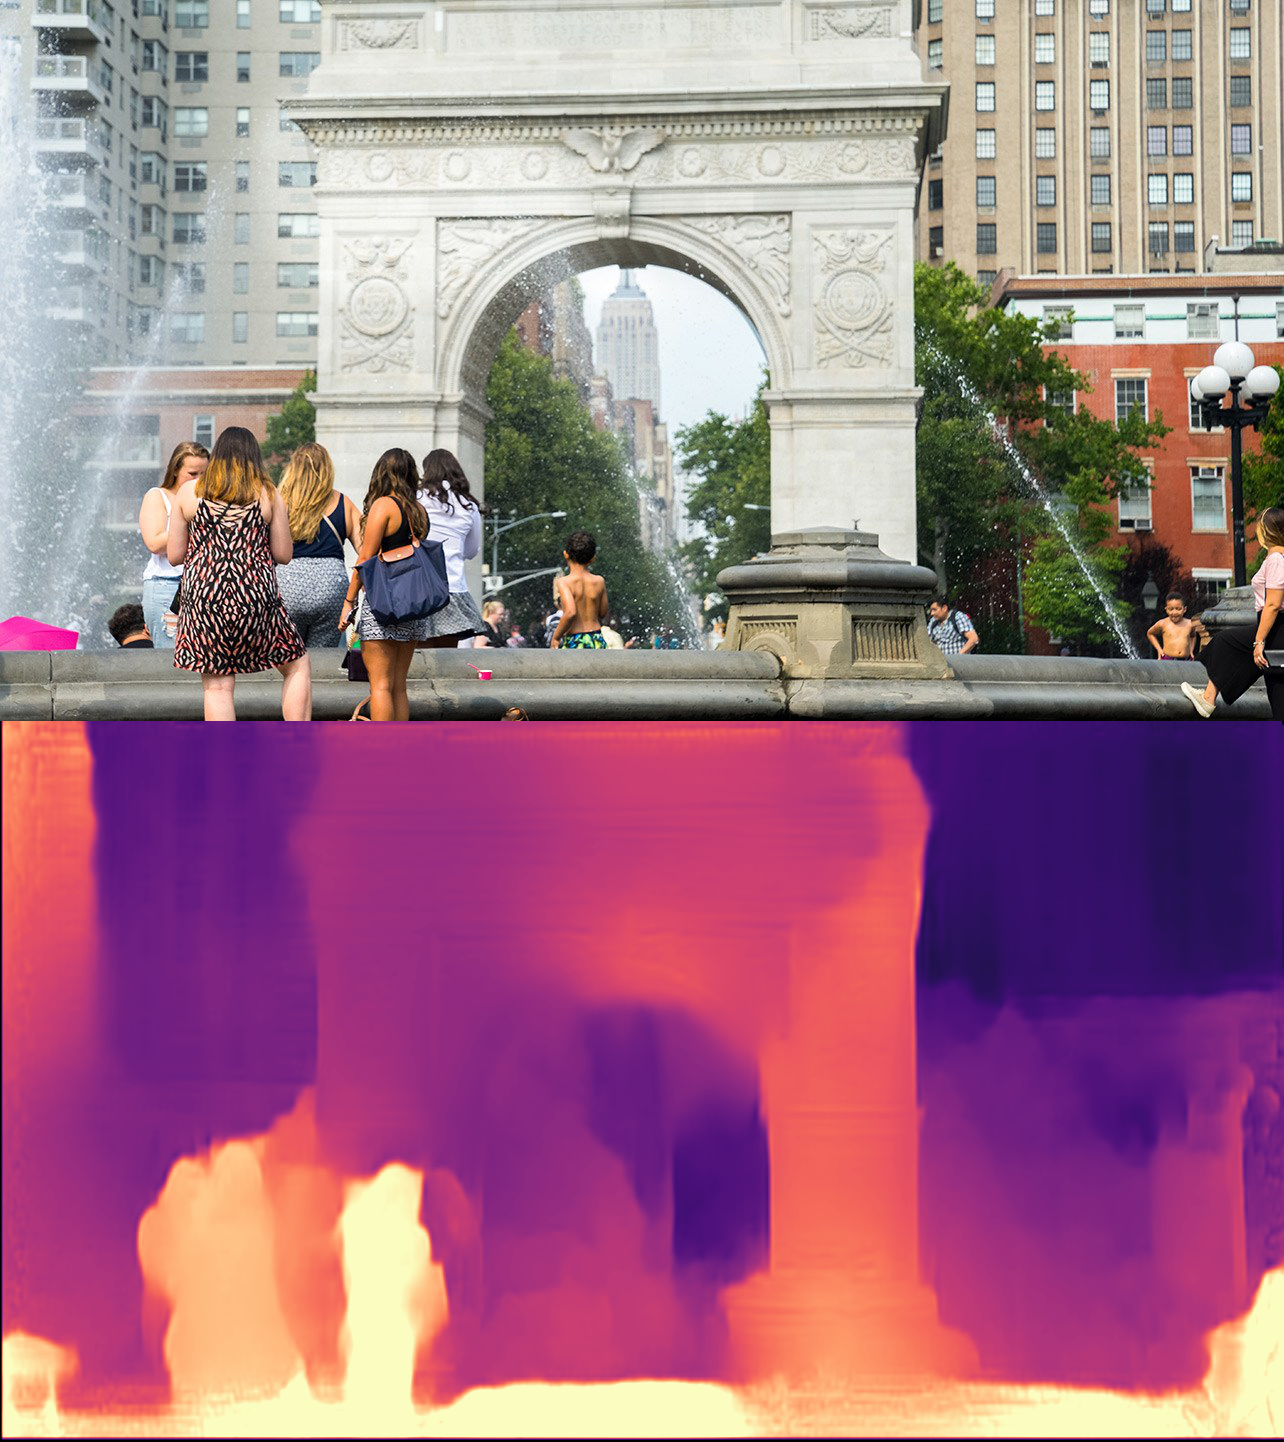

In [55]:
dest

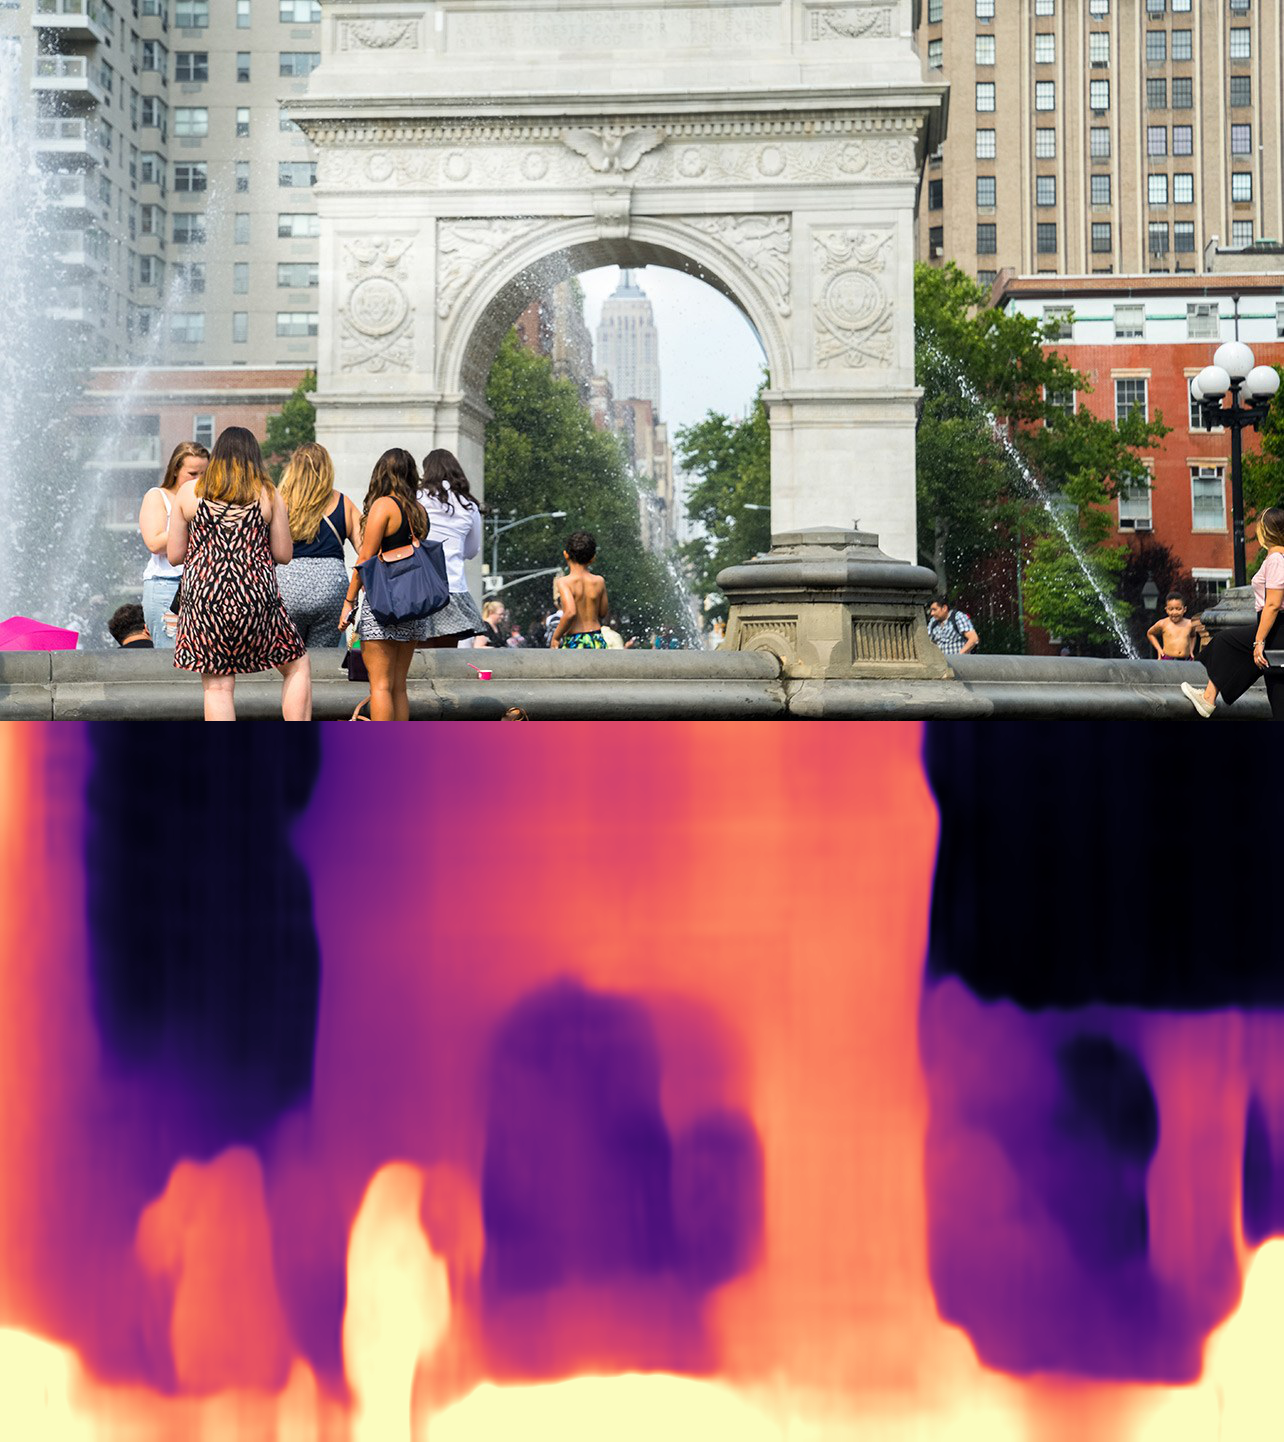

In [66]:
dest

In [162]:
outpath = imgPath.split(".")
outpath = ".".join(outpath[:-1]) + "_pred_{}_espcn-{}.".format(modelName, espcn) + outpath[-1]
dest.save(outpath)